In [5]:
import sys
sys.path.append('../coding')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from analysis.information import AdaptationChannel
from analysis.plotting import pmf_plot

publication_directory = '../manuscript'

%matplotlib inline

In [2]:
def arrowed_spines(fig, ax):

    xmin, xmax = ax.get_xlim() 
    ymin, ymax = ax.get_ylim()

    # removing the default axis on all sides:
    for side in ['bottom','right','top','left']:
        ax.spines[side].set_visible(False)

    # removing the axis ticks
#     plt.xticks([]) # labels 
#     plt.yticks([])
#     ax.xaxis.set_ticks_position('none') # tick markers
#     ax.yaxis.set_ticks_position('none')

    # get width and height of axes object to compute 
    # matching arrowhead length and width
    dps = fig.dpi_scale_trans.inverted()
    bbox = ax.get_window_extent().transformed(dps)
    width, height = bbox.width, bbox.height

    # manual arrowhead width and length
    hw = 1./20.*(ymax-ymin) 
    hl = 1./20.*(xmax-xmin)
    lw = 2. # axis line width
    ohg = 0.3 # arrow overhang

    # compute matching arrowhead length and width
    yhw = hw/(ymax-ymin)*(xmax-xmin)* height/width 
    yhl = hl/(xmax-xmin)*(ymax-ymin)* width/height

    # draw x and y axis
    ax.arrow(xmin, ymin, xmax-xmin, 0., fc='k', ec='k', lw = lw, 
             head_width=hw, head_length=hl, overhang = ohg, 
             length_includes_head= True, clip_on = False) 

    ax.arrow(xmin, ymin, 0., ymax-ymin, fc='k', ec='k', lw = lw, 
             head_width=yhw, head_length=yhl, overhang = ohg, 
             length_includes_head= True, clip_on = False)

In [4]:
neurons = ['RS','IB','FS','CH']
inh_ratio = 0.
tw = 1000

res_df = pd.read_pickle('../data/transition_rates.pkl').loc[inh_ratio, tw, neurons]
efficiencies = {}

for ix, sub_df in res_df.groupby(level=[0,1,2]):
    channel = AdaptationChannel(sub_df.loc[ix])
    efficiencies[ix] = channel.obtain_efficiency(method='jimbo')
    print(ix)

efficiencies = pd.Series(efficiencies).loc[inh_ratio, tw].loc[neurons]

/Users/tomasbarta/Documents/skola/doktorat/ms-thesis/program/optimization/__init__.py:7: RuntimeWarning: invalid value encountered in true_divide
  specificity = sr_grid / prior


(0.0, 1000, 'CH')
(0.0, 1000, 'FS')
(0.0, 1000, 'IB')
(0.0, 1000, 'RS')


In [6]:
from matsim import ShotNoiseConductance, OUConductance, Neuron, get_mat

In [7]:
RS = get_mat('RS')
IB = get_mat('IB')
FS = get_mat('FS')
CH = get_mat('CH')

neuron = Neuron(
    resting_potential=-80,
    membrane_resistance=50,
    membrane_capacitance=0.1,
    mats=[RS, IB, FS, CH]
)

exc = ShotNoiseConductance(
    rate=2.67,
    g_peak=0.0015,
    reversal=0,
    decay=3)

inh = ShotNoiseConductance(
    rate=3.73,
    g_peak=0.0015,
    reversal=-75,
    decay=10)

neuron.append_conductance(exc)
neuron.append_conductance(inh)

In [8]:
def intensity_freq_func(intensity, B):
    exc = 2.67 * intensity
    inh = 3.73 * (1 + B * (intensity - 1))
    return exc, inh

def get_spike_times(intensities):
    dt = 0.1
    time = 500

    neuron.time = 0
    RS.reset_spike_times()
    IB.reset_spike_times()
    FS.reset_spike_times()
    CH.reset_spike_times()

    for intensity in intensities:
        tot_time = 0

        exc_intensity, inh_intensity = intensity_freq_func(intensity, B=0.2)

        exc.set_rate(exc_intensity)
        inh.set_rate(inh_intensity)

        while tot_time < time:
            tot_time += dt
            neuron.timestep(dt)

    return {
        'RS': RS.get_spike_times(),
        'FS': FS.get_spike_times(),
        'IB': IB.get_spike_times(),
        'CH': CH.get_spike_times()
    }

def channel_spikes(neuron, n_windows=5):
    info_res = efficiencies.loc[neuron]
    intensities = np.random.choice(np.logspace(0, 1.6, 100), p=info_res['pdf'], size=n_windows)
    
    spike_times = get_spike_times(intensities)[neuron]
    
    return spike_times

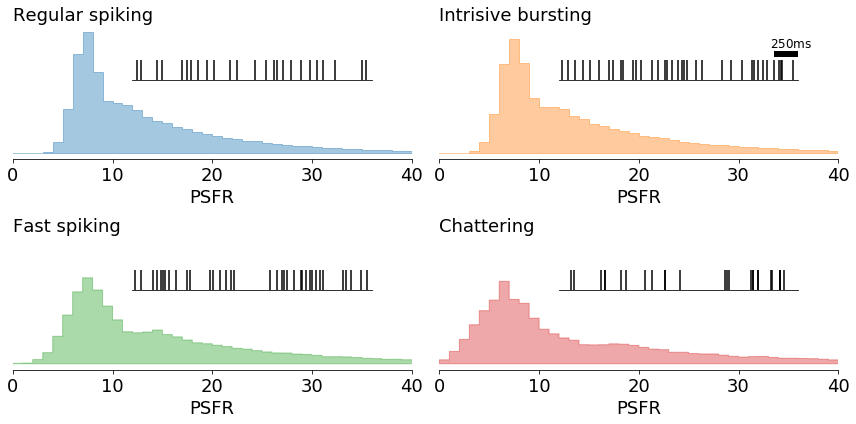

In [54]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,6), sharey=True)

scale_fontsize = 12

name_map = {
    'RS': 'Regular spiking',
    'IB': 'Intrisive bursting',
    'FS': 'Fast spiking',
    'CH': 'Chattering'
}

colors = {
    'RS': 'C0',
    'IB': 'C1',
    'FS': 'C2',
    'CH': 'C3'
}

for (ix, eff), ax in zip(efficiencies.iteritems(), axes.flat):
    outs = np.arange(len(eff['out_pdf']))
#     ax.step(outs, eff['out_pdf'])
    ax.fill_between(outs, eff['out_pdf'], step="pre", alpha=0.4, color=colors[ix])
#     pmf_plot(eff['out_pdf'], ax=ax, c='C2')
    ax.set_title(name_map[ix], loc='left')
    ax.set_xlim((0, 40))
    
    ins = ax.inset_axes([0.3,0.6,0.6,0.15])
    ins.set_xlim(0, 2500)
    ins.set_ylim(0, 1)
    
    if ix == 'IB':
        e = ins.errorbar(x=2250 + 125, y=1.3, xerr=125, c='black', lw=6)
        for b in e[2]:
            b.set_clip_on(False)
        ins.text(x=2200, y=1.6, s=r'$250\mathrm{ms}$', fontsize=scale_fontsize)
    
#     ax.errorbar(x=2250+125, y=0.2, xerr=125, c='black', lw=6)
#     ax.text(x=2300, y=0.5, s=r'$\Delta=250\mathrm{ms}$', fontsize=scale_fontsize)
    
    for side in ['right','top','left']:
        ins.spines[side].set_visible(False)
    
    ins.set_xticks([])
    ins.set_yticks([])
    
    spike_times = channel_spikes(ix)
    for st in spike_times:
        ins.axvline(st, c='black')
    
#     arrowed_spines(fig, ax)
    for side in ['right','top','left']:
        ax.spines[side].set_visible(False)

    ax.set_yticks([])
    ax.set_xlabel('PSFR')

fig.tight_layout()
plt.savefig(f'{publication_directory}/img/out_pmfs.pdf')